<a href="https://colab.research.google.com/github/pratik-kadlak/Weights-Biases/blob/main/dl_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
k = len(class_names)

## Question 1

4422102/4422102 [==============================] - 0s 0us/step


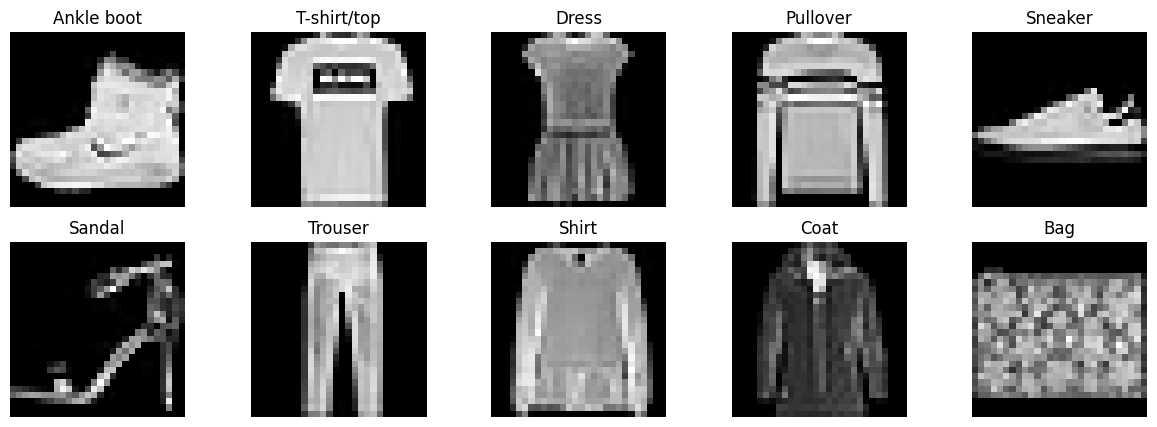

In [ ]:
def plotImagesOfEachClass():
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    image_labels = []
    images = []

    for i in range(len(X_train)):
        if(len(image_labels) == len(class_names)):
            break
        if class_names[y_train[i]] not in image_labels:
            image_labels.append(class_names[y_train[i]])
            images.append(np.array(X_train[i]))

    num_rows = 2
    num_cols = 5

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

    for i in range(len(images)):
        row_idx = i // num_cols
        col_idx = i % num_cols

        axes[row_idx, col_idx].axis("off")
        axes[row_idx, col_idx].imshow(images[i], cmap="gray")
        axes[row_idx, col_idx].set_title(image_labels[i])


    plt.show()


plotImagesOfEachClass()

##Question 2

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
k = len(class_names)

# loading the data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

#flattening the images, originally images is of size 28x28, converting it to 784x1
X_train  = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_train = np.array(X_train / 255.0)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
X_test = np.array(X_test / 255.0)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
def initializeWeightAndBias(layer_dims, mode):
    W = []
    b = []
    np.random.seed(42)

    for l in range(len(layer_dims)-1):
        if mode == "random_uniform":
            W.append(np.random.uniform(-0.7, 0.7, (layer_dims[l+1], layer_dims[l])))
            b.append(np.random.uniform(-0.7, 0.7, (layer_dims[l+1],1)))
        elif mode == "xavier":
            W.append(np.random.randn(layer_dims[l+1],layer_dims[l])*np.sqrt(2/(layer_dims[l+1]+layer_dims[l])))
            b.append(np.zeros((layer_dims[l+1], 1)))
        else:
            W.append(np.random.randn(layer_dims[l+1], layer_dims[l]))
            b.append((np.random.randn(layer_dims[l+1],1)))

    return W, b

In [ ]:
def sigmoid(X):
    return 1.0/(1.+np.exp(-X))


def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))


def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)


def tanh(x):
    return np.tanh(x)


def tanh_derivative(x):
    return 1 - np.tanh(x)**2


def softmax(a):
    return np.exp(a)/np.sum(np.exp(a), axis=0)


def cross_entropy(y, y_hat):
    loss = 0
    for i in range(len(y)):
        loss += -1.0 * y[i] * np.log(y_hat[i])
    return loss

In [ ]:
def forward_propogation(W, b, X, num_hidden_layers, layer_dims, activation_func):
    preactivation = []
    activation = []
    preactivation.append(X.T)
    activation.append(X.T)

    for i in range(1, num_hidden_layers+1):
        preactivation.append(b[i-1] + np.matmul(W[i-1], activation[(i-1)]))
        if activation_func == "sigmoid":
            activation.append(sigmoid(preactivation[i]))
        elif activation_func == "relu":
            activation.append(relu(preactivation[i]))
        elif activation_func == "tanh":
            activation.append(tanh(preactivation[i]))

    preactivation.append(b[-1] + np.dot(W[-1], activation[-1]))
    activation.append(softmax(preactivation[-1]))
    return activation[-1], activation, preactivation

In [ ]:
def generate_one_hot(n, true_label):
    '''
        generates one hot matrix, where the ith col gives the one hot vector for the ith image
        and in that vector only the row number of true class will be 1 and rest will be zero
    '''

    y_one_hot = np.zeros((10,n))
    for i in range(n):
        y_one_hot[true_label[i]][i] = 1
    return y_one_hot

In [ ]:
def update_parameters(W, grad_W, b, grad_b, eta):
    """
    normal gradient descent
    """
    for i in range(0, len(W)):
        W[i] = W[i] - eta * grad_W[i]
        b[i] = b[i] - eta * grad_b[i]
    return W, b


def update_parameters_mgd(W, grad_W, b, grad_b, eta, beta, W_history, b_history):
    """
    momentum based gradient descent
    """
    for t in range(len(W)):
        W_history[t] = beta * W_history[t] + grad_W[t]
        b_history[t] = beta * b_history[t] + grad_b[t]
    for i in range(len(W)):
        W[i] = W[i] - eta * W_history[i]
        b[i] = b[i] - eta * b_history[i]
    return W, b


In [ ]:
def backward_propogation(y_one_hot, activation, preactivation, num_hidden_layers, activation_func):
    L = num_hidden_layers+1
    grad_preactivation = []
    grad_preactivation.append(activation[L]-y_one_hot)

    grad_W = []
    grad_b = []

    for i in range(L, 0, -1):
        grad_W.append(np.matmul(grad_preactivation[-1], activation[i-1].T))
        grad_b.append(np.sum(grad_preactivation[-1], axis=1, keepdims=True))
        if i == 1:
            break
        if activation_func == "sigmoid":
            grad_preactivation.append(np.multiply(np.matmul(W[i-1].T, grad_preactivation[-1]), sigmoid_derivative(preactivation[i-1])))
        elif activation_func == "relu":
            grad_preactivation.append(np.multiply(np.matmul(W[i-1].T, grad_preactivation[-1]), relu_derivative(preactivation[i-1])))
        elif activation_func == "tanh":
            grad_preactivation.append(np.multiply(np.matmul(W[i-1].T, grad_preactivation[-1]), tanh_derivative(preactivation[i-1])))

    return grad_W[::-1], grad_b[::-1]

In [ ]:
from tqdm import tqdm

num_hidden_layers = 2
size_of_hidden_layer = 64
activation_func = "relu"
mode = "xavier"
num_images = 60000
batch_size = 60
epoch = 10
eta = 0.001
beta = 0.9
optimizer = "momentum"
W_history = [0] * (num_hidden_layers+1)
b_history = [0] * (num_hidden_layers+1)

# preparing the layer_dims list
layer_dims = [X_train.shape[1]]
for i in range(num_hidden_layers):
    layer_dims.append(size_of_hidden_layer)
layer_dims.append(k)


# Initialize W, b
W, b = initializeWeightAndBias(layer_dims, mode)
# y_one_hot = generate_one_hot(num_images, y_train)

y_hat = []
for iteration in tqdm(range(10)):

    for i in range(0, num_images, batch_size):
        if i <= num_images-batch_size:
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

        hL, activation, preactivation = forward_propogation(W, b, X_batch, num_hidden_layers, layer_dims, activation_func)
        y_one_hot = generate_one_hot(batch_size, y_batch)
        grad_W, grad_b = backward_propogation(y_one_hot, activation, preactivation, num_hidden_layers, activation_func)

        if optimizer == "momentum":
            W, b = update_parameters_mgd(W, grad_W, b, grad_b, eta, beta, W_history, b_history)
        else:
            W, b = update_parameters(W, grad_W, b, grad_b, eta)


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


In [ ]:
y_hat, _, _ = forward_propogation(W, b, X_test, num_hidden_layers, layer_dims, activation_func)

In [ ]:
y_pred = []

for i in range(len(y_hat[0])):
    y_pred.append(np.argmax(y_hat[:, i]))

In [ ]:
correct = 0
for i in range(len(y_pred)):
    if(y_pred[i] == y_test[i]):
        correct += 1

In [ ]:
correct

8684

In [ ]:
correct * 100.0 / len(y_test)

86.84

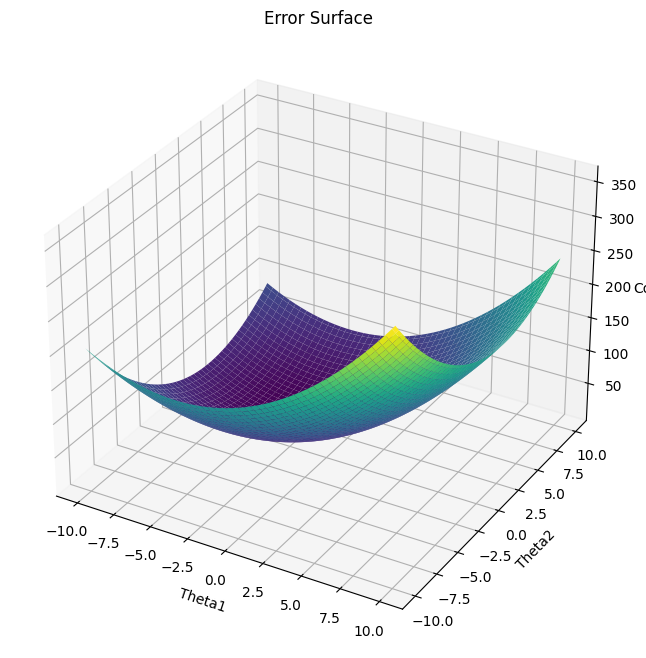

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def compute_cost(theta1, theta2):
    # Replace this function with your actual cost function
    # It should take parameters theta1 and theta2 and return the cost
    # For example, for a linear regression model:
    # cost = np.sum((X @ np.array([theta1, theta2]) - Y)**2) / (2 * m)
    # where X is your input data, Y is your target, and m is the number of samples.
    # Adjust this according to your specific model.

    # Example cost function (replace this with your own):
    cost = (theta1 - 3)**2 + (theta2 + 4)**2
    return cost

# Generate a grid of theta1 and theta2 values
theta1_values = np.linspace(-10, 10, 100)
theta2_values = np.linspace(-10, 10, 100)

theta1_mesh, theta2_mesh = np.meshgrid(theta1_values, theta2_values)
cost_values = np.zeros_like(theta1_mesh)

# Compute the cost for each combination of theta1 and theta2
for i in range(len(theta1_values)):
    for j in range(len(theta2_values)):
        cost_values[i, j] = compute_cost(theta1_values[i], theta2_values[j])

# Plotting the error surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(theta1_mesh, theta2_mesh, cost_values, cmap='viridis')
ax.set_xlabel('Theta1')
ax.set_ylabel('Theta2')
ax.set_zlabel('Cost')

plt.title('Error Surface')
plt.show()


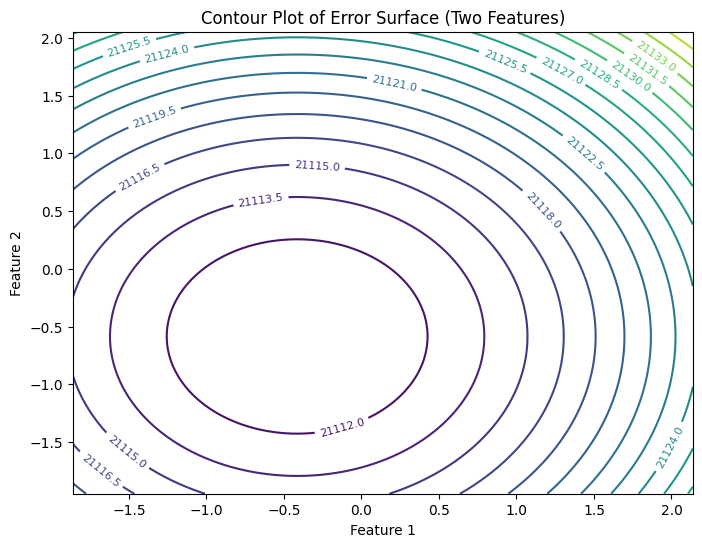

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_cost(theta):
    # Replace this function with your actual cost function
    # It should take parameters theta and return the cost
    # Adjust this according to your specific model.

    # Example cost function (replace this with your own):
    cost = np.sum((theta - 3)**2) + np.sum((theta + 4)**2)
    return cost

# Generate random initial parameters (replace with your actual initial parameters)
theta_initial = np.random.randn(784)

# Create a grid of values for two selected dimensions (you can change these dimensions)
dim1_values = np.linspace(theta_initial[0] - 2, theta_initial[0] + 2, 100)
dim2_values = np.linspace(theta_initial[1] - 2, theta_initial[1] + 2, 100)

theta1_mesh, theta2_mesh = np.meshgrid(dim1_values, dim2_values)
cost_values = np.zeros_like(theta1_mesh)

# Compute the cost for each combination of theta1 and theta2
for i in range(len(dim1_values)):
    for j in range(len(dim2_values)):
        theta = np.copy(theta_initial)
        theta[0] = dim1_values[i]
        theta[1] = dim2_values[j]
        cost_values[i, j] = compute_cost(theta)

# Contour plot
plt.figure(figsize=(8, 6))
contour = plt.contour(theta1_mesh, theta2_mesh, cost_values, levels=20)
plt.clabel(contour, inline=True, fontsize=8)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Contour Plot of Error Surface (Two Features)')
plt.show()
